/tmp/ipykernel_2724997/1959301058.py:112: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(bin_centers_dens[::2], hist_dens[::2], color=clist[idx], s=7, marker='+', lw=0.8, alpha=0.8, edgecolors='none', zorder=2)


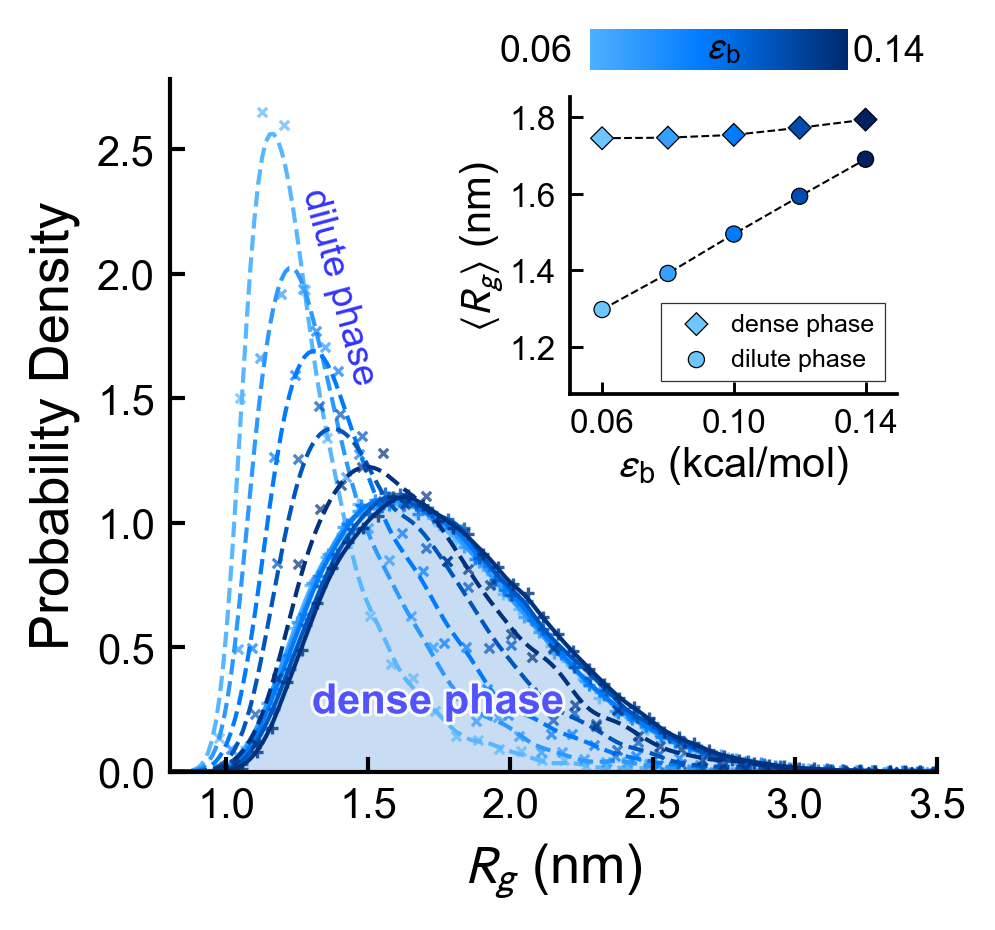

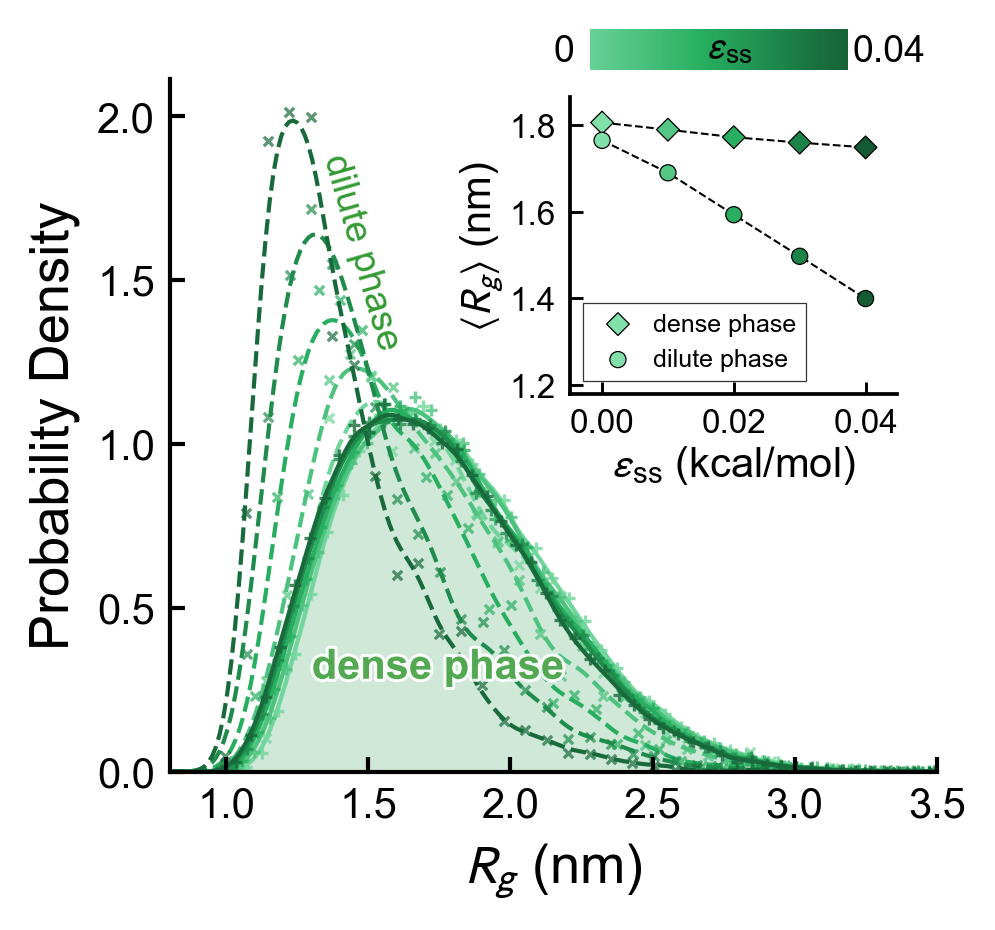

In [ ]:
import os
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde  # [Added] For smooth curve fitting

def apply_pub_style(ax, remove_spines=True):
    ax.tick_params(direction='in', which='both', labelsize=10, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)
    ax.set_axisbelow(False)

def rg2param(fixed_part, nbins=100):

    protein = 'poly50'
    fig, ax = plt.subplots(1, 1, figsize=[3.3, 3], facecolor='w', dpi=300)
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['axes.linewidth'] = 1.0 
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['xtick.minor.width'] = 0.8
    plt.rcParams['ytick.minor.width'] = 0.8
    plt.rcParams['mathtext.fontset'] = 'stixsans'
    plt.rcParams['mathtext.default'] = 'it'
    
    # Assuming apply_pub_style is defined elsewhere, if not, comment it out
    apply_pub_style(ax) 

    if fixed_part == 'e_w':
        cmap_full = LinearSegmentedColormap.from_list("vibrant_blue", ["#6EC6FF", "#007BFF", "#002060"], N=256)
        param_list = np.arange(0.06, 0.16, 0.02)
        clist = cmap_full(np.linspace(0.1, 0.9, len(param_list)))
    if fixed_part == 'e_b':
        cmap_full = LinearSegmentedColormap.from_list("vibrant_green", ["#82E0AA", "#27AE60", "#145A32"], N=256)
        param_list = np.arange(0.00, 0.05, 0.01)
        clist = cmap_full(np.linspace(0.1, 0.9, len(param_list)))
    
    rg_cp, rg_dp = [], []
    
    # [Added] Define x-axis range for smooth curve evaluation
    x_grid = np.linspace(0.8, 3.5, 200)

    for idx in range(len(param_list)):

        param = param_list[idx]
        if fixed_part == 'e_w':
            T_sim = 160
            folder = 'des_0.20_%.2f_0.02'%param
            label = '$\epsilon_{\mathregular{b}}$'
        if fixed_part == 'e_b':
            T_sim = 160
            folder = 'des_0.20_0.12_%.2f'%param
            label = '$\epsilon_{\mathregular{ss}}$'
        datafile = 'data/%s/%s/%i_rg.npy'%(protein, folder, T_sim)

        ## --- Dense Phase Processing ---
        if os.path.exists(datafile):
            rg = np.load(datafile)
        else:
            nres = 50
            neq = 300
            nskip = 2
            dcdfile = 'traj/%s/%s/%i/%i.dcd'%(protein, folder, T_sim, T_sim)
            gsdfile = 'traj/%s/%s/%i/%i.gsd'%(protein, folder, T_sim, T_sim)
            u = mda.Universe(gsdfile, dcdfile)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / nres)
            rg = []
            for frame in np.arange(neq, nlen, nskip):
                print(frame)
                ts = u.trajectory[frame]
                for i in range(nchains):
                    mol = u.select_atoms("index %i:%i"%(i * nres, (i + 1) * nres - 1))
                    mda.lib.mdamath.make_whole(mol)
                    rg.append((frame, mol.radius_of_gyration()))
            rg = np.array(rg)
            data = rg[:, 1]
            data[np.where(data > 10)] = None
            rg[:, 1] = data
            np.save('data/%s/%s/%i_rg.npy'%(protein, folder, T_sim), rg)

        # Data preparation
        data_dense = rg[:, 1]
        data_dense = data_dense[data_dense <= 10] # Filter outlines
        rg_cp.append(np.mean(data_dense))

        # 1. Calculate Histogram (Original Data Points)
        hist_dens, bins_dens = np.histogram(data_dense, bins=nbins, density=True)
        bin_centers_dens = 0.5 * (bins_dens[1:] + bins_dens[:-1])

        # 2. KDE Fitting (Theoretical Smooth Curve)
        kde_dens = gaussian_kde(data_dense)
        y_smooth_dens = kde_dens(x_grid)

        # 3. Plotting Dense Phase
        # Fill area
        ax.fill_between(x_grid, 0, y_smooth_dens, color=clist[idx], alpha=0.05, zorder=1)
        # Smooth curve
        ax.plot(x_grid, y_smooth_dens, color=clist[idx], linestyle='-', lw=1., 
                label=r'%s = %.2f'%(label, param), zorder=2)
        # Raw data points (Scatter) - decimated for visual clarity
        ax.scatter(bin_centers_dens[::2], hist_dens[::2], color=clist[idx], s=7, marker='+', lw=0.8, alpha=0.8, edgecolors='none', zorder=2)


        ## --- Dilute Phase Processing (Single Chain) ---
        # [Assuming file reading logic is correct]
        dcdfile_sc = '../rg/traj/tmp1/%s/%s/%s_%i.dcd'%(protein, folder, protein, T_sim)
        gsdfile_sc = '../rg/traj/tmp1/%s/%s/%s_%i.gsd'%(protein, folder, protein, T_sim)
        try:
            u_sc = mda.Universe(gsdfile_sc, dcdfile_sc)
            at1 = u_sc.select_atoms('all')
            rg_single_chain = np.zeros(len(u_sc.trajectory))
            for tdx, ts in enumerate(u_sc.trajectory):
                mda.lib.mdamath.make_whole(at1)
                rg_single_chain[tdx] = at1.radius_of_gyration()
        except:
            # Fallback for testing or if file missing
            rg_single_chain = np.random.normal(1.2 + idx*0.1, 0.1, 500) 
        # ------------------------------------------------------------------

        rg_dp.append(np.mean(rg_single_chain))

        # 1. Calculate Histogram
        hist_dil, bins_dil = np.histogram(rg_single_chain, bins=nbins, density=True)
        bin_centers_dil = 0.5 * (bins_dil[1:] + bins_dil[:-1])

        # 2. KDE Fitting
        kde_dil = gaussian_kde(rg_single_chain)
        y_smooth_dil = kde_dil(x_grid)

        # 3. Plotting Dilute Phase
        # Smooth curve (Dashed)
        ax.plot(x_grid, y_smooth_dil, color=clist[idx], linestyle='--', lw=1., zorder=2)
        # Raw data points (Scatter, different marker)
        ax.scatter(bin_centers_dil[::2], hist_dil[::2], color=clist[idx], s=5, marker='x', alpha=0.7, lw=0.8, zorder=2)


    # --- Formatting & Decoration ---
    plt.xlabel(r'$R_g$ (nm)', fontsize=13)
    plt.ylabel('Probability Density', fontsize=13)
    plt.xlim(0.8, 3.5)
    plt.ylim(ymin=0)
    
    if fixed_part == 'e_w':
        text = ax.text(0.35, 0.1, "dense phase", transform=ax.transAxes, 
                ha='center', va='center', fontsize=10, 
                color='b', alpha=0.4, fontweight='bold')
        text.set_path_effects([
            path_effects.withStroke(linewidth=1.5, foreground='w', alpha=0.9),
            path_effects.Normal()
        ])
        ax.text(0.22, 0.7, "dilute phase", transform=ax.transAxes, 
                ha='center', va='center', fontsize=9, rotation=-75,
                color='b', alpha=0.8, fontweight='normal')
    if fixed_part == 'e_b':
        text = ax.text(0.35, 0.15, "dense phase", transform=ax.transAxes, 
                ha='center', va='center', fontsize=10, 
                color='g', alpha=0.4, fontweight='bold')
        text.set_path_effects([
            path_effects.withStroke(linewidth=1.5, foreground='w', alpha=0.9),
            path_effects.Normal()
        ])
        ax.text(0.25, 0.75, "dilute phase", transform=ax.transAxes, 
                ha='center', va='center', fontsize=9, rotation=-74,
                color='g', alpha=0.8, fontweight='normal')

    if fixed_part == 'e_b':
        plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0])

    # Colorbar
    cbar_ax = fig.add_axes([0.55, 0.89, 0.26, 0.045])
    cmap_partial = mpl.colors.ListedColormap(cmap_full(np.linspace(0.15, 0.95, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])

    # Parameter Labels
    if fixed_part == 'e_w':
        plt.text(0.7, 1.03, r'$\epsilon_\mathregular{b}$', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.43, 1.025, '0.06', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.89, 1.025, '0.14', transform=ax.transAxes, fontsize=9, zorder=10)
    if fixed_part == 'e_b':
        plt.text(0.7, 1.03, r'$\epsilon_\mathregular{ss}$', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.50, 1.025, '0', transform=ax.transAxes, fontsize=9, zorder=10)
        plt.text(0.89, 1.025, '0.04', transform=ax.transAxes, fontsize=9, zorder=10)

    # --- Inset Plot ---
    axin = fig.add_axes([0.53, 0.53, 0.33, 0.33])
    # Smooth connecting lines for inset
    axin.plot(param_list, rg_cp, '--k', lw=0.5, zorder=1)
    axin.plot(param_list, rg_dp, '--k', lw=0.5, zorder=1)
    # Scatter points
    axin.scatter(param_list, rg_cp, marker='D', c=param_list, cmap=cmap_full, s=15, 
                 label='dense phase', edgecolors='k', linewidths=0.3, zorder=10)
    axin.scatter(param_list, rg_dp, marker='o', c=param_list, cmap=cmap_full, s=15, 
                 label='dilute phase', edgecolors='k', linewidths=0.3, zorder=10)
    
    axin.set_xlabel(r'%s (kcal/mol)'%label, fontsize=10, labelpad=1)
    axin.set_ylabel(r'$\langle R_g\rangle$ (nm)', fontsize=10, labelpad=1)
    
    # Legend in Inset
    loc_leg = 'lower right' if fixed_part == 'e_w' else 'lower left'
    leg = axin.legend(fontsize=6, loc=loc_leg, frameon=True, fancybox=False, edgecolor="black", handletextpad=0.4)
    leg.get_frame().set_linewidth(0.3)
    
    # Inset styling
    axin.tick_params(labelsize=8, direction='in', length=3, width=0.7)
    axin.set_xticks(param_list[::2])
    
    # Dynamic limits
    param_range = max(param_list) - min(param_list)
    axin.set_xlim(min(param_list)-0.12*param_range, max(param_list)+0.12*param_range)
    # Handle case where rg lists might be empty if files missing (just for safety)
    if rg_dp and rg_cp:
        axin.set_ylim(min(rg_dp)-0.22, max(rg_cp)+0.06)
    
    axin.yaxis.set_major_locator(MultipleLocator(0.2))
    axin.spines['top'].set_visible(False)
    axin.spines['right'].set_visible(False)
    axin.spines['left'].set_linewidth(0.9)
    axin.spines['bottom'].set_linewidth(0.9)

    plt.savefig(f"../../figures/rg/rg-{fixed_part}_optimized.svg", format="svg", bbox_inches='tight')
    plt.show()

rg2param('e_w')
rg2param('e_b')

des_0.20_0.06_0.02


/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(sorted(unique_bonds)), 4)
/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyobjects.py:600: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  guessed = np.asarray(guessed, dtype=np.bool)
/tmp/ipykernel_3337360/190503545.py:32: RuntimeWarning: invalid value encountered in power
  return A * 

des_0.20_0.14_0.02
des_0.20_0.12_0.00
des_0.20_0.12_0.04
des_0.20_0.12_0.02
des_0.20_0.08_0.02
des_0.20_0.12_0.01
des_0.20_0.10_0.02
des_0.20_0.12_0.03


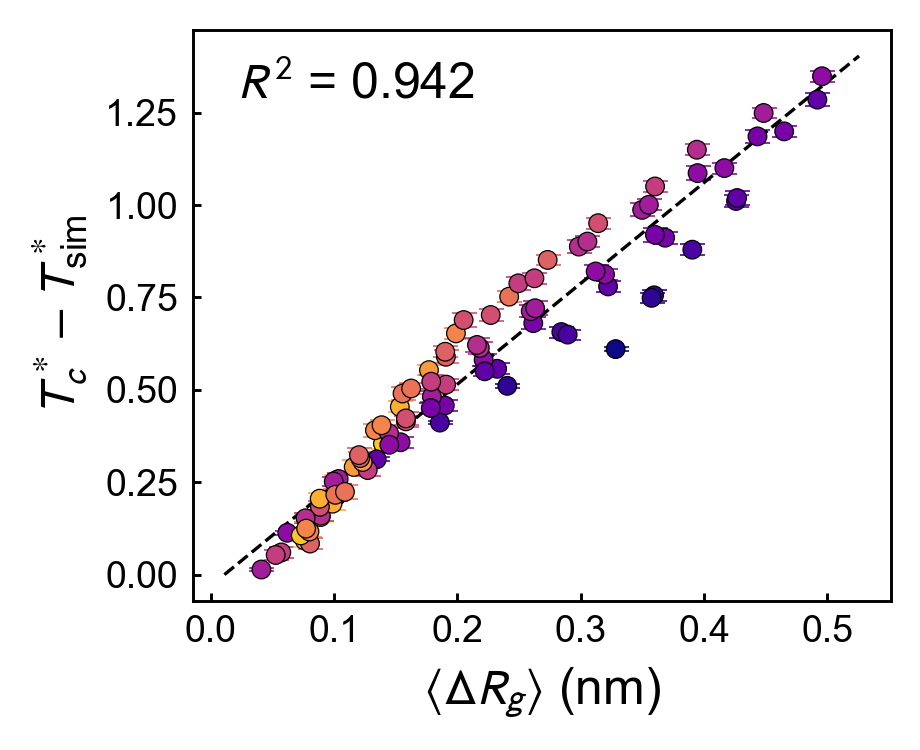

In [33]:
## Fig.3 C

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

def apply_pub_style(ax, remove_spines=True):
    ax.tick_params(direction='in', which='both', labelsize=10, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)
    ax.set_axisbelow(False)

def deltarho2t(t, A, Tc):
    beta = 0.325
    return A * (Tc - t)**beta

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

protein = 'poly50'
delta_rg_list, delta_rg_std, tsim_list, tc_list, tc_err_list = [], [], [], [], []
folders = os.listdir('traj/' + protein)
nbins = 500
for folder in folders:
    param = folder.split('_')
    if len(param) == 1: # removing HPS model or not
        continue
    if len(param) != 1 and param[1] != '0.20':
        continue
    print(folder)
    rho_dense_list, rho_dilute_list, tsim_list_temp = [], [], []
    for temp in range(0, 1000, 10):
        param = folder.split('_')
        slab_dir = 'traj/{}/{}/{}/{}'.format(protein, folder, temp, temp)
        single_dir = '../rg/traj/tmp1/{}/{}/{}_{}'.format(protein, folder, protein, temp)
        if (not os.path.exists(f'{slab_dir}.gsd')) or (not os.path.exists(f'{single_dir}.gsd')):
            continue

        # calculate phase density
        rho_data = f'data/{protein}/{folder}/{temp}_dp.npy'
        if os.path.exists(rho_data):
            rhoave = np.load(rho_data)
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(300, nlen, 2):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(rho_data, rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue

        tsim_list_temp.append(temp)
        rho_dense_list.append(rho_hd)
        rho_dilute_list.append(rho_ld)

        # calculate dense phase rg
        data_slab_rg = 'data/{}/{}/{}_rg.npy'.format(protein, folder, temp)
        if os.path.exists(data_slab_rg):
            rg = np.load(data_slab_rg)
        else:
            nres = 50
            neq = 300
            nskip = 2
            u = mda.Universe(f'{slab_dir}.gsd', f'{slab_dir}.dcd')
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            nchains = int(natoms / nres)
            rg = []
            for frame in np.arange(neq, nlen, nskip):
                ts = u.trajectory[frame]
                for i in range(nchains):
                    mol = u.select_atoms("index %i:%i"%(i * nres, (i + 1) * nres - 1))
                    mda.lib.mdamath.make_whole(mol)
                    rg.append((frame, mol.radius_of_gyration()))
            rg = np.array(rg)
            data = rg[:, 1]
            data[np.where(data > 10)] = None
            rg[:, 1] = data
            np.save(data_slab_rg, rg)

        hist, bins = np.histogram(rg[:, 1], bins=50, density=True)
        rg_dense = np.mean(rg[:, 1])
        rg_dense_std = np.std(rg[:, 1])

        # calculate dilute phase rg
        u = mda.Universe(f'{single_dir}.gsd', f'{single_dir}.dcd')
        at1 = u.select_atoms('all')
        nlen = len(u.trajectory)
        natoms = at1.n_atoms
        rg = np.zeros(nlen)
        for tdx, ts in enumerate(u.trajectory):
            mda.lib.mdamath.make_whole(at1)
            rg[tdx] = at1.radius_of_gyration()
        
        hist, bins = np.histogram(rg, bins=50, density=True)
        rg_dilute = np.mean(rg)
        rg_dilute_std = np.std(rg)

        delta_rg_list.append(rg_dense - rg_dilute)
        delta_rg_std.append(math.sqrt(rg_dense_std**2 + rg_dilute_std**2))
        
    delta_rho = np.array(rho_dense_list) - np.array(rho_dilute_list)
    T_prods = np.array(tsim_list_temp)
    param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho))
    A, T_c = param[0]

    popt, pcov = curve_fit(deltarho2t, T_prods, delta_rho, p0 = [200, T_c])
    Tc_val = popt[1]
    Tc_err = np.sqrt(np.diag(pcov))[1]

    tc_list.extend([Tc_val]*len(tsim_list_temp))
    tsim_list.extend(tsim_list_temp)
    tc_err_list.extend([Tc_err]*len(tsim_list_temp))

delta_t_list = np.array(tc_list) - np.array(tsim_list)

fig, ax = plt.subplots(1, 1, figsize=[3.1, 2.6], facecolor='w', dpi=300)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['mathtext.default'] = 'it'

cmap = cm.plasma
norm = plt.Normalize(vmin=min(tsim_list), vmax=max(tsim_list))

for rg, t, rg_std, tc_std, tsim in zip(delta_rg_list, delta_t_list, delta_rg_std, tc_err_list, tsim_list):
    plt.errorbar(x=rg, y=t*0.009935, yerr=tc_std*0.009935, fmt='.', color=cmap(norm(tsim)), ecolor=cmap(norm(tsim)), elinewidth=1., capsize=3, capthick=0.4, markersize=2)
plt.scatter(delta_rg_list, delta_t_list*0.009935, s=20, c=tsim_list, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=2*len(tsim_list))

z = np.polyfit(delta_rg_list, delta_t_list, 1)
p = np.poly1d(z)
pc = np.corrcoef(delta_rg_list, delta_t_list)[0, 1]
R2 = r2_score(delta_t_list, p(delta_rg_list))

delta_rg_fit_range = np.linspace(min(delta_rg_list)-0.03, max(delta_rg_list)+0.03, 10)
plt.plot(delta_rg_fit_range, p(delta_rg_fit_range)*0.009935, 'k--', lw=0.8)
plt.text(min(delta_rg_list)-0.02, (max(delta_t_list)-6)*0.009935, r'$R^2$ = %.3f'%R2, fontsize=12)

plt.xlabel(r'$\langle \Delta R_g \rangle$ (nm)', fontsize=12)
plt.ylabel(r'$T_c^* - T_\mathregular{sim}^*$', fontsize=12)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
for spine in ax.spines.values():
    spine.set_linewidth(0.7)

# norm = mpl.colors.Normalize(vmin=min(tsim_list), vmax=max(tsim_list))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# dv = make_axes_locatable(ax)
# cb = fig.colorbar(sm, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08))
# cb.set_label(label='Temperature (K)', size=11)
# cb.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

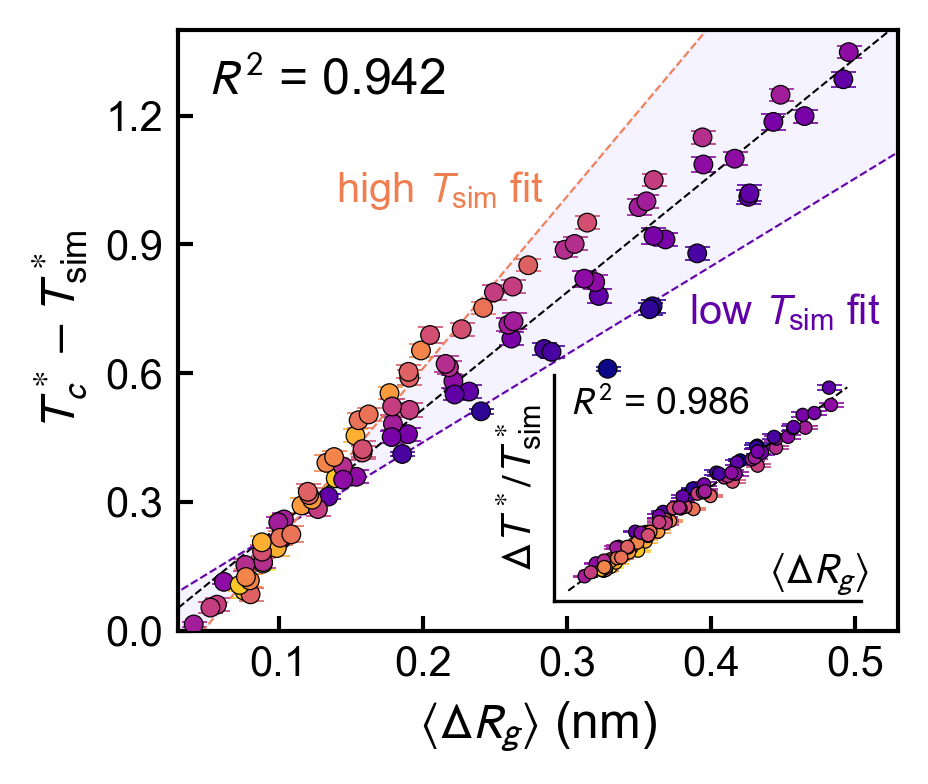

In [48]:
fig, ax = plt.subplots(1, 1, figsize=[3.1, 2.6], facecolor='w', dpi=300)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['mathtext.default'] = 'it'
apply_pub_style(ax, remove_spines=False)

cmap = cm.plasma
norm = plt.Normalize(vmin=min(tsim_list), vmax=max(tsim_list))

for rg, t, rg_std, tc_std, tsim in zip(delta_rg_list, delta_t_list, delta_rg_std, tc_err_list, tsim_list):
    ax.errorbar(x=rg, y=t*0.009935, yerr=tc_std*0.009935, fmt='.', color=cmap(norm(tsim)), ecolor=cmap(norm(tsim)), elinewidth=1., capsize=3, capthick=0.4, markersize=2)
plt.scatter(delta_rg_list, delta_t_list*0.009935, s=20, c=tsim_list, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=2*len(tsim_list))

z = np.polyfit(delta_rg_list, delta_t_list, 1)
p = np.poly1d(z)
pc = np.corrcoef(delta_rg_list, delta_t_list)[0, 1]
R2 = r2_score(delta_t_list, p(delta_rg_list))

mask_low = np.where(np.array(tsim_list)*0.009935<1.2)
z_low = np.polyfit(np.array(delta_rg_list)[mask_low], np.array(delta_t_list)[mask_low], 1)
p_low = np.poly1d(z_low)

mask_high = np.where(np.array(tsim_list)*0.009935>2.4)
z_high = np.polyfit(np.array(delta_rg_list)[mask_high], np.array(delta_t_list)[mask_high], 1)
p_high = np.poly1d(z_high)

delta_rg_fit_range = np.linspace(min(delta_rg_list)-0.1, max(delta_rg_list)+0.1, 1000)
fit_line = p(delta_rg_fit_range)*0.009935
fit_line_low = p_low(delta_rg_fit_range)*0.009935
fit_line_high = p_high(delta_rg_fit_range)*0.009935
plt.plot(delta_rg_fit_range, fit_line, 'k--', lw=0.5)
plt.plot(delta_rg_fit_range, fit_line_low, ls='--', lw=0.5, color=cmap(norm(min(tsim_list)*1.3)))
plt.plot(delta_rg_fit_range, fit_line_high, ls='--', lw=0.5, color=cmap(norm(max(tsim_list)*0.8)))
plt.fill_between(delta_rg_fit_range, fit_line_low, fit_line_high, color='#EDE8FF', alpha=0.5)
plt.text(min(delta_rg_list)+0.01, (max(delta_t_list)-10)*0.009935, r'$R^2$ = %.3f'%R2, fontsize=12)
# plt.text(0.28, 0.43, r'low $T_\mathregular{sim}$ fit', fontsize=9, color=cmap(norm(min(tsim_list)*1.3)))
plt.text(0.385, 0.715, r'low $T_\mathregular{sim}$ fit', fontsize=10, color=cmap(norm(min(tsim_list)*1.3)))
plt.text(0.14, 1, r'high $T_\mathregular{sim}$ fit', fontsize=10, color=cmap(norm(max(tsim_list)*0.8)))

plt.xlim(0.03, 0.53)
plt.ylim(0, 1.4)
plt.xlabel(r'$\langle \Delta R_g \rangle$ (nm)', fontsize=12)
plt.ylabel(r'$T_c^* - T_\mathregular{sim}^*$', fontsize=12)
# plt.tick_params(labelsize=9, direction='in', length=2, width=0.6)
plt.yticks([0, 0.3, 0.6, 0.9, 1.2])
# for spine in ax.spines.values():
#     spine.set_linewidth(0.6)

axin = fig.add_axes([0.53, 0.148, 0.33, 0.29])
for rg, t, rg_std, tc_std, tsim in zip(delta_rg_list, delta_t_list, delta_rg_std, tc_err_list, tsim_list):
    axin.errorbar(x=rg, y=t/tsim, yerr=tc_std/tsim, fmt='.', color=cmap(norm(tsim)), ecolor=cmap(norm(tsim)), elinewidth=1., capsize=3, capthick=0.4, markersize=2)
axin.scatter(delta_rg_list, delta_t_list/np.array(tsim_list), s=10, c=tsim_list, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=2*len(tsim_list))
z = np.polyfit(delta_rg_list, delta_t_list/np.array(tsim_list), 1)
p = np.poly1d(z)
pc = np.corrcoef(delta_rg_list, delta_t_list/np.array(tsim_list))[0, 1]
R2 = r2_score(delta_t_list/np.array(tsim_list), p(delta_rg_list))
delta_rg_fit_range = np.linspace(min(delta_rg_list)-0.03, max(delta_rg_list)+0.03, 10)
axin.plot(delta_rg_fit_range, p(delta_rg_fit_range), 'k--', lw=0.5)
axin.set_xticks([])
axin.set_yticks([])
# axin.set_ylabel(r'$(T_c^*-T_\mathregular{sim}^*)\,/\,T_\mathregular{sim}^*$', fontsize=7, labelpad=-1)
axin.set_ylabel(r'$\Delta T^*/T_\mathregular{sim}^*$', fontsize=10, labelpad=-1)
axin.text(0.7, 0.08, r'$\langle\Delta R_g\rangle$', fontsize=10, transform=axin.transAxes)
axin.text(0.05, 0.82, r'$R^2$ = %.3f'%R2, fontsize=9, transform=axin.transAxes)
axin.spines['top'].set_visible(False)
axin.spines['right'].set_visible(False)
axin.spines['left'].set_linewidth(0.8)
axin.spines['bottom'].set_linewidth(0.8)
axin.set_facecolor('none')

# plt.tight_layout()
plt.savefig(f"../../figures/rg/deltat2deltarg.svg", format="svg", bbox_inches='tight')
plt.show()

Fit: y = exp(2.77) * x^0.41


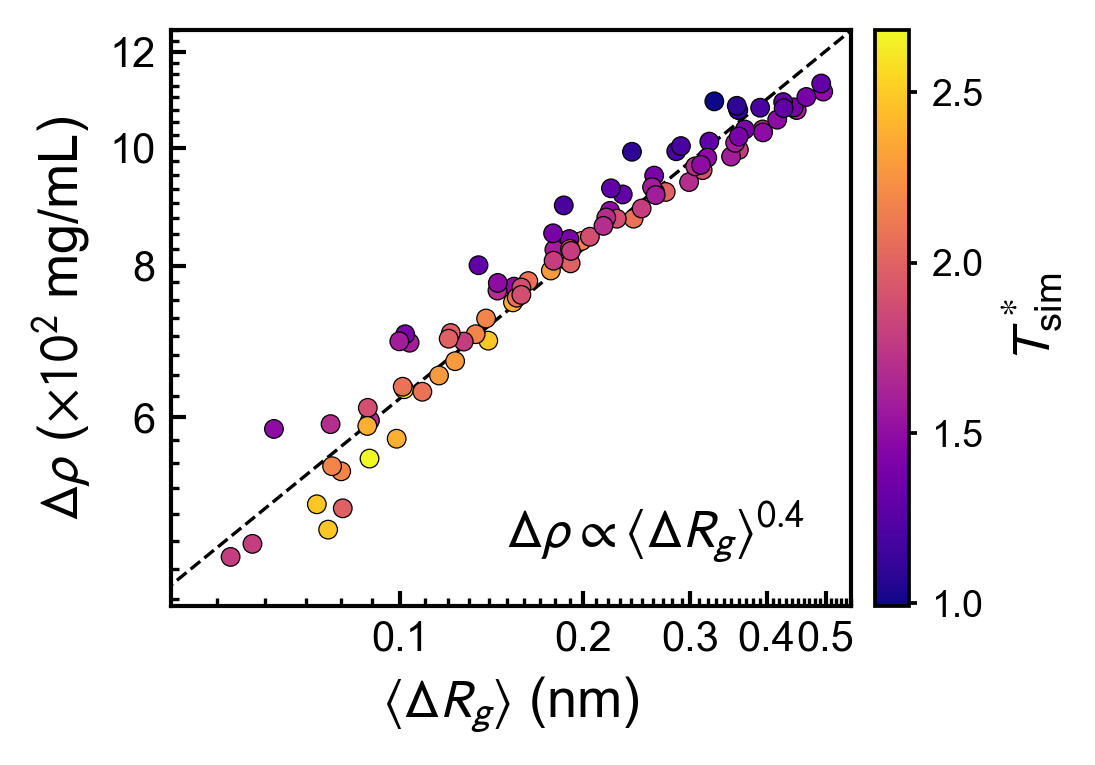

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score
from matplotlib.ticker import FixedLocator, ScalarFormatter, NullFormatter

fig, ax = plt.subplots(1, 1, figsize=[3.75, 2.65], facecolor='w', dpi=300)

# Style settings (kept as requested)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['mathtext.default'] = 'it'
# apply_pub_style(ax, remove_spines=False) # Uncomment if function exists

delta_rho_100 = delta_rho / 100  # Scale delta_rho by 100 for better readability
# 1. Scatter plot using RAW data
scatter = plt.scatter(delta_rg, delta_rho_100, s=20, c=np.array(T)*0.009935, 
                      cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=10)

# 2. Set Log-Log Scale
ax.set_xscale('log')
ax.set_yscale('log')

# 3. Fitting (Perform fit in log space, convert for display)
log_x = np.log(delta_rg)
log_y = np.log(delta_rho_100)
z = np.polyfit(log_x, log_y, 1) # z[0]=slope, z[1]=intercept
p_log = np.poly1d(z) 
print(f"Fit: y = exp({z[1]:.2f}) * x^{z[0]:.2f}")

# Calculate R2
R2 = r2_score(log_y, p_log(log_x))

# Plot Fit Line (Generate points in log space, transform to linear)
xaxis_range_log = np.linspace(min(log_x)*1.2, max(log_x)*0.8, 20)
xaxis_range = np.exp(xaxis_range_log) # Convert x back to real scale
yaxis_fit = np.exp(p_log(xaxis_range_log)) # Convert y_fit back to real scale

plt.plot(xaxis_range, yaxis_fit, 'k--', lw=0.8)

# 4. Text Annotation (Positioning adapted for log scale)
# Position: slightly left of max X, slightly above min Y
text_x = np.exp(max(log_x) - 1.2) 
text_y = np.exp(min(log_y) + 0.4)
plt.text(text_x, text_y, r'$\Delta\rho \propto \langle \Delta R_g\rangle^{0.4}$', fontsize=13)

# 5. Axis Labels (Removed \ln)
plt.xlabel(r'$\langle \Delta R_g\rangle$ (nm)', fontsize=13)
plt.ylabel(r'$\Delta \rho$ ($\times 10^2$ mg/mL)', fontsize=13)

# 6. Manual Ticks Configuration
# Define formatter to avoid "10^x" notation, prefer "0.1", "100"
formatter = ScalarFormatter()
formatter.set_scientific(False)

# X-Axis Ticks: Range approx 0.05 to 7.4
# Specific ticks to show scale clearly
ax.xaxis.set_major_locator(FixedLocator([0.1, 0.2, 0.3, 0.4, 0.5]))
ax.xaxis.set_major_formatter(formatter)
x_minor_ticks = np.arange(0.05, 0.61, 0.01)
ax.xaxis.set_minor_locator(FixedLocator(x_minor_ticks))

# Y-Axis Ticks: Range approx 445 to 1200
# Since range < 1 decade, we force specific linear intervals to show log compression
ax.yaxis.set_major_locator(FixedLocator([6, 8, 10, 12]))
ax.yaxis.set_major_formatter(formatter)
y_minor_ticks = np.arange(4, 13.01, 0.25)
ax.yaxis.set_minor_locator(FixedLocator(y_minor_ticks))

ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())

ax.tick_params(which='minor', direction='in')
ax.tick_params(which='major', direction='in')

# Set limits slightly wider than ticks to avoid clipping
plt.ylim(4.2, 12.5) 
plt.xlim(0.042, 0.55)

# Colorbar (Kept largely the same)
dv = make_axes_locatable(ax)
cb = fig.colorbar(mappable=scatter, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08), 
                  ticks=[1, 1.5, 2, 2.5])
cb.set_label(label=r'$T_\mathregular{sim}^*$', size=13)
cb.ax.tick_params(labelsize=9, length=2, width=0.9)
for spine in cb.ax.spines.values():
    spine.set_linewidth(0.9)

plt.tight_layout()
plt.savefig(f"../../figures/rg/deltarho2deltarg.svg", format="svg", bbox_inches='tight')
plt.show()